<a href="https://colab.research.google.com/github/GinWeng/AI4E2024/blob/main/Week_5_W_MCEN90048_2024_S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week 5: Batch Normalisation, Label Smoothing, and Data Augmentation

We will be using the CIFAR-10 data set for this tutorial

https://en.wikipedia.org/wiki/CIFAR-10

The CIFAR-10 dataset contains 50,000 32x32 color images in 10 different classes.The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 5,000 images of each class.

### 1. Plain CNN

Let's try the following CNN model on CIFAR-10, a color image dataset with 10 classes.

| Index | Layer (activation) | channels | height x weight |
|:---:|:---:|:---:|:---:|
| layer 0 |  Input  |   3  | 32x32  |
| layer 1 |  Conv (ReLU) |  16 | 16x16 |
| layer 2 |  Conv (ReLU) |  32 | 8x8 |
| layer 3 |  Conv (ReLU) |  64 | 4x4 |
| layer 4 |  max-pool |  64 | 1x1 |
| layer 5 | Output (softmax) | 10 | 1x1 |

Use this network as your base model.

In [1]:

import torch
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
import random

import torchvision.transforms as transforms

# Training will be significantly faster if GPU is available. In Colab, go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")
# set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


GPU is available


In [2]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

data_train = trainset.data
label_train = trainset.targets
data_test = testset.data
label_test = testset.targets

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(data_train[0].max(), data_train[0].min())

100%|██████████| 170M/170M [00:06<00:00, 25.0MB/s]


255 0


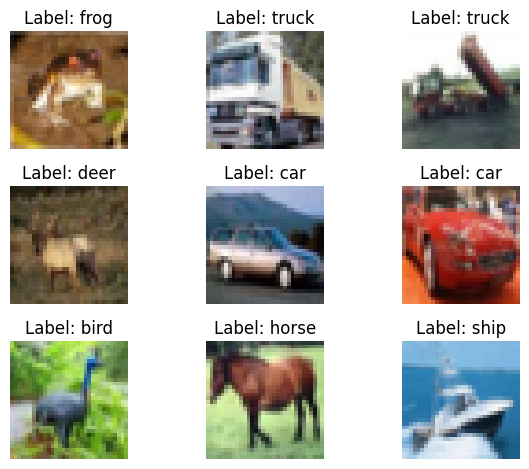

In [3]:
# Display 9 images and their labels
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(data_train[i])
    plt.title(f"Label: {classes[label_train[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
data_train.shape

(50000, 32, 32, 3)

In [5]:
# Scaling the values from 0 to 1 and converting to tensor
data_train_norm = torch.tensor(data_train / 255.0).float()
data_test_norm = torch.tensor(data_test / 255.0).float()

# One-hot encode the labels
label_train = torch.tensor(label_train)
label_test = torch.tensor(label_test)
y_train_val = torch.nn.functional.one_hot(label_train, num_classes=len(classes)).float()
y_test = torch.nn.functional.one_hot(label_test, num_classes=len(classes)).float()

# CNN expects the data to be in the format (batch, channels, height, width)
# batch is the number of images
# channels is the number of color channels (for grayscale images - 1, colour images - 3)
# height and width are the dimensions of the image
x_train_val = data_train_norm.permute(0, 3, 1, 2)
x_test = data_test_norm.permute(0, 3, 1, 2)

In [6]:
print(x_train_val.shape, x_test.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([10000, 3, 32, 32])


In [7]:

# Split the data into training and validation sets
random.seed(42)
train_idx = random.sample(range(len(x_train_val)), int(0.8 * len(data_train)))
val_idx = list(set(range(len(x_train_val))) - set(train_idx))

x_train = x_train_val[train_idx]
y_train = y_train_val[train_idx]
x_val = x_train_val[val_idx]
y_val = y_train_val[val_idx]

# Create TensorDatasets for train, validation, and test data
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create data loaders for train, validation, and test data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=4)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))

        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create an instance of the CNN model
model = CNN().to(device)


In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Set the number of epochs
num_epochs = 20

# Lists to store the training and validation losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Initialize the training loss and accuracy for this epoch
    train_loss = 0
    train_correct = 0
    train_total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:

        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
        # Update the training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, labels_reshape = torch.max(labels, 1)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels_reshape.size(0)
        train_correct += (predicted == labels_reshape).sum().item()

    # update the learning rate based on LR schedule
    scheduler.step()

    # Compute the average training loss and accuracy for this epoch
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * train_correct / train_total

    # Append the training loss and accuracy to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Set the model to evaluation mode
    model.eval()

    # Initialize the validation loss and accuracy for this epoch
    val_loss = 0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move the inputs and labels to the GPU if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Update the validation loss and accuracy
            val_loss += loss.item() * inputs.size(0)
            _, labels_reshape = torch.max(labels, 1)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels_reshape.size(0)
            val_correct += (predicted == labels_reshape).sum().item()

    # Compute the average validation loss and accuracy for this epoch
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * val_correct / val_total

    # Append the validation loss and accuracy to the lists
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the training and validation metrics for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")
    print()


In [ ]:
# Test the model on train data
model.eval()
train_loss = 0
train_correct = 0
train_total = 0

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        _, labels_reshape = torch.max(labels, 1)
        train_correct += (predicted == labels_reshape).sum().item()
        train_loss += criterion(outputs, labels_reshape).item()

train_accuracy = 100 * train_correct / train_total
train_loss /= len(train_loader)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Train Loss: {train_loss:.4f}")

# Test the model on test data
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, labels_reshape = torch.max(labels, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels_reshape).sum().item()
        test_loss += criterion(outputs, labels_reshape).item()

test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")



### 2. Batch normalization (BN)

In BN, we do "Z-score" to some intermediate outputs $x$, e.g., logits:
$$z = \frac{x-\mu_{x}}{\sigma_x}\cdot\gamma+\beta$$
where in the training phase, $\mu_x,\sigma_x$ are the mean and std estimated from the batch; during test, $\mu_x,\sigma_x$ are obtained from the moving average of the statistics during training phase; $\gamma,\beta$ are learnable scale and offset.

([read here TF tutorial on other normalization methods](https://www.tensorflow.org/addons/tutorials/layers_normalizations))

Add a batch normalisation layer to the above baseline model, and compare the training. (Google BatchNormalisation layer in tf.keras)

In [ ]:
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=4)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = nn.ReLU()(self.bn3(self.conv3(x)))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x




In [ ]:
# Create an instance of the CNN model
model_bn = CNN_BN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Set the number of epochs
num_epochs = 20

# Lists to store the training and validation losses and accuracies
train_losses = []
train_accuracies = []
val_losses_bn = []
val_accuracies_bn = []

# Training loop
for epoch in range(num_epochs):
    # Set the model_bn to training mode
    model_bn.train()

    # Initialize the training loss and accuracy for this epoch
    train_loss = 0
    train_correct = 0
    train_total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:

        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        outputs = model_bn(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
        # Update the training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, labels_reshape = torch.max(labels, 1)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels_reshape.size(0)
        train_correct += (predicted == labels_reshape).sum().item()

    # update the learning rate based on LR schedule
    scheduler.step()

    # Compute the average training loss and accuracy for this epoch
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * train_correct / train_total

    # Append the training loss and accuracy to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Set the model_bn to evaluation mode
    # Note that Batch Normalization has different behaviors during training and test.
    # calling model_bn.eval() will change the behaviour to test mode.

    model_bn.eval()

    # Initialize the validation loss and accuracy for this epoch
    val_loss = 0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move the inputs and labels to the GPU if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_bn(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Update the validation loss and accuracy
            val_loss += loss.item() * inputs.size(0)
            _, labels_reshape = torch.max(labels, 1)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels_reshape.size(0)
            val_correct += (predicted == labels_reshape).sum().item()

    # Compute the average validation loss and accuracy for this epoch
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * val_correct / val_total

    # Append the validation loss and accuracy to the lists
    val_losses_bn.append(val_loss)
    val_accuracies_bn.append(val_accuracy)

    # Print the training and validation metrics for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")
    print()


In [ ]:
# Test the model_bn on train data
model_bn.eval()
train_loss = 0
train_correct = 0
train_total = 0

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_bn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        _, labels_reshape = torch.max(labels, 1)
        train_correct += (predicted == labels_reshape).sum().item()
        train_loss += criterion(outputs, labels_reshape).item()

train_accuracy = 100 * train_correct / train_total
train_loss /= len(train_loader)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Train Loss: {train_loss:.4f}")

# Test the model_bn on test data
model_bn.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_bn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, labels_reshape = torch.max(labels, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels_reshape).sum().item()
        test_loss += criterion(outputs, labels_reshape).item()

test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")



In [ ]:
# Plot the progress
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

ax1.set_xlabel('epoch')
ax1.set_ylabel('Cross entropy loss')
ax1.plot(np.arange(0, num_epochs), val_losses, color='tab:red', label='Validation loss')
ax1.plot(np.arange(0, num_epochs), val_losses_bn, color='tab:blue', label='Training loss')
ax1.tick_params(axis='y')
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(np.arange(0, num_epochs), val_accuracies, color='tab:red', label='Validation accuracy', linestyle='dashed')
ax2.plot(np.arange(0, num_epochs), val_accuracies_bn, color='tab:blue', label='Training accuracy', linestyle='dashed')
ax2.tick_params(axis='y')
ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### 3. Label smoothing

To prevent over-confident predictions, one may either:
* with a small probability $p$ (e.g, 0.1), randomly change the label of an instance to other class(es);
* for each one-hot label vector, change $1$ to $(1-p+\frac{p}{C})$ and $0$ to $\frac{p}{C}$ where $C$ is the number of classes.

These two approaches are equivalent (can you explain why?). In practice, we usually use the second approach.

Apply label smoothing to both the Plain CNN and CNN+BN.

(Google label smoothing tf.keras)

Plot their trajectories together with the two above.

In [ ]:
model_bn_ls = CNN_BN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model_bn_ls.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:

# Set the number of epochs
num_epochs = 20

# Lists to store the training and validation losses and accuracies
train_losses = []
train_accuracies = []
val_losses_bn_ls = []
val_accuracies_bn_ls = []

# Training loop
for epoch in range(num_epochs):
    # Set the model_bn_ls to training mode
    model_bn_ls.train()

    # Initialize the training loss and accuracy for this epoch
    train_loss = 0
    train_correct = 0
    train_total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:

        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        outputs = model_bn_ls(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
        # Update the training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, labels_reshape = torch.max(labels, 1)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels_reshape.size(0)
        train_correct += (predicted == labels_reshape).sum().item()

    # update the learning rate based on LR schedule
    scheduler.step()

    # Compute the average training loss and accuracy for this epoch
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * train_correct / train_total

    # Append the training loss and accuracy to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Set the model_bn_ls to evaluation mode
    # Note that Batch Normalization has different behaviors during training and test.
    # calling model_bn_ls.eval() will change the behaviour to test mode.

    model_bn_ls.eval()

    # Initialize the validation loss and accuracy for this epoch
    val_loss = 0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move the inputs and labels to the GPU if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_bn_ls(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Update the validation loss and accuracy
            val_loss += loss.item() * inputs.size(0)
            _, labels_reshape = torch.max(labels, 1)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels_reshape.size(0)
            val_correct += (predicted == labels_reshape).sum().item()

    # Compute the average validation loss and accuracy for this epoch
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * val_correct / val_total

    # Append the validation loss and accuracy to the lists
    val_losses_bn_ls.append(val_loss)
    val_accuracies_bn_ls.append(val_accuracy)

    # Print the training and validation metrics for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")
    print()


In [ ]:
# Test the model_bn_ls on train data
model_bn_ls.eval()
train_loss = 0
train_correct = 0
train_total = 0

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_bn_ls(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        _, labels_reshape = torch.max(labels, 1)
        train_correct += (predicted == labels_reshape).sum().item()
        train_loss += criterion(outputs, labels_reshape).item()

train_accuracy = 100 * train_correct / train_total
train_loss /= len(train_loader)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Train Loss: {train_loss:.4f}")

# Test the model_bn_ls on test data
model_bn_ls.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_bn_ls(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, labels_reshape = torch.max(labels, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels_reshape).sum().item()
        test_loss += criterion(outputs, labels_reshape).item()

test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")



**Exercise:** Plot the training and validation losses and accuracies for the models with and without label smoothing.

In [ ]:
# Plot the progress of the plain CNN, CNN with Batch Normalization, and CNN with Batch Normalization and Label Smoothing
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()



### 4. Data Augmentation



Data augmentation can be used to increase the size of the training set by applying random transformations to the images. In PyTorch, data augmentation can be applied using the torchvision.transforms module.

Here are some common data augmentation techniques:
- RandomHorizontalFlip: Flips the image horizontally with a probability of 0.5
- RandomVerticalFlip: Flips the image vertically with a probability of 0.5
- RandomRotation: Rotates the image by a random angle between -degrees and degrees
- RandomResizedCrop: Resizes the image to a random size and aspect ratio
- ColorJitter: Adjusts the brightness, contrast, saturation, and hue of the image
- RandomAffine: Applies a random affine transformation to the image
- RandomPerspective: Applies a random perspective transformation to the image

In [ ]:
import torchvision.transforms as transforms

# Define the transformations for data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
])

# Apply the transformations to the training dataset
transformed_x_train = []
for image in x_train:
    augmented_image = transform(image)
    transformed_x_train.append(augmented_image)

# Convert the augmented data to a tensor
transformed_x_train = torch.stack(transformed_x_train)
augmented_x_train = torch.cat((transformed_x_train, x_train))
y_train = torch.concat((y_train, y_train))

print(augmented_x_train.shape, x_train.shape)

# Create a TensorDataset for the augmented data
augmented_train_dataset = TensorDataset(augmented_x_train, y_train)
augmented_train_dataloader = DataLoader(augmented_train_dataset,
                                        batch_size=batch_size, shuffle=True)

**Exercise**

Train the best model from the above exercises with the augmented dataset.

Plot the training against the previous models.

In [ ]:
model_bn_ls_aug = CNN_BN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = optim.SGD(model_bn_ls_aug.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Training Loop

In [ ]:
# Test the model on test data



In [ ]:
# Plot the progress and compare all 4 models
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()
